In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

## Ссылки:
* [Chris Olah's blog (LSTM/GRU)](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)
* [PyTorch tutorial - RNN for name classification](https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html)
* [MNIST classification with RNN tutorial](https://medium.com/dair-ai/building-rnns-is-fun-with-pytorch-and-google-colab-3903ea9a3a79)
* [Good tutorials about Torch sentiment](https://github.com/bentrevett/pytorch-sentiment-analysis)

## Vanilla RNN

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="600">

$$\Large h_{i+1} = tanh(W_x \cdot X_{i+1} + W_y \cdot h_{i})$$

Рекурретные нейросети нужны для работы с **последовательными данными** произвольной длины. Они представляют собой абстрактные ячейки, у которых есть какая-то **память** (hidden state), которая обновляется после обработки очередной порции данных.

Если в самом простом виде, то в рекуррентных сетках для одного входного вектора $x_{(t)}$ и одного слоя рекуррентной сети справедливо такое соотношение:

$$y_{(t)} = \phi (x_{(t)}^T \cdot w_x + y_{(t-1)}^T \cdot w_y + b)$$

где 
* $x(t)$ — входной вектор на текущем шаге;
* $y(t)$ — выходной вектор на текущем шаге;
* $w_x$ — вектор весов нейронов для входа;
* $w_y$ — вектор весов нейронов для выхода;
* $y(t-1)$ — выходной вектор с прошлого шага (для первого шага этот вектор нулевой);
* $b$ — bias;
* $\phi$ — какая-то функция активации (например, ReLU).

Эту ячейку применяют по очереди ко всей последовательности, пробрасывая hidden state с предыдущего состояния. С точки зрения построения вычислительного графа это выглядит так:

<img src="http://colah.github.io/posts/2015-08-Understanding-LSTMs/img/RNN-unrolled.png" width="600">

То есть если зафиксировать длину последовательности, то мы получим обычный фиксированный ациклический граф вычислений, в котором просто пошерены параметры всех ячеек.

### Упрощение формулы

Снова немножко математики чтобы привести формулу выше к более удобному виду.

Представим, что на вход подается не один вектор $x_{(t)}$, а целый мини-батч размера $m$ таких векторов $X_{(t)}$, соответственно все дальнейшие размышления мы уже производим в матричном виде:

$$ Y_{(t)} = \phi(X_{(t)}^T \cdot W_x + Y_{(t-1)}^T \cdot W_y + b) = \phi([X_{(t)} Y_{(t-1)}] \cdot W + b) $$
где
$$ W = [W_x W_y]^T $$

*Операция в квадратных скобках — конкатенация матриц

По размерностям:
* $Y_{(t)}$ — матрица [$m$ x n_neurons]
* $X_{(t)}$ — матрица [$m$ x n_features]
* $b$ — вектор длины n_neurons
* $W_x$ — веса между входами и нейронами размерностью [n_features x n_neurons]
* $W_y$ — веса связей с прошлым выходом размерностью [n_neurons x n_neurons]

# RNN from scratch

**Disclaimer:** не используйте самописные RNN-ки в реальной жизни.

Давайте реализуем торчовый модуль, который это реализует.

In [ ]:
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.Wx = np.random.random()

    def forward(self, input_data, hidden):
        hidden = nn.Tanh(np.dot(np.concatenate(input_data, hidden), np.concatenate(self.Wx, self.Wy).T))
        return hidden

    def init_hidden(self):
        return torch.zeros(1, self.hidden_size)

In [ ]:
input_feature_size = 6
hidden_size=5
batch_size=1

In [ ]:
rnn = RNN(input_size=input_feature_size, hidden_size=hidden_size)
initial_hidden = rnn.init_hidden(batch_size)

In [ ]:
input_example = torch.rand([batch_size, input_feature_size])
new_hidden = rnn(input_example, initial_hidden)

In [ ]:
print(new_hidden.shape)

In [ ]:
print("initial_hidden: ", initial_hidden.numpy())
print("new_hidden: ", new_hidden.detach().numpy())

In [ ]:
new_hidden = rnn(input_example, new_hidden)
print("new_hidden: ", new_hidden.detach().numpy())

**Задание**. Модифицируйте код так, чтобы на вход можно было подавать батчи размером больше 1.

# Классификация картинок с RNN

Представьте, что у вас есть какая-то длинная картинка, в которой свёртки точно не зайдут. Например, снимки со спутника, спектрограмма или длиннокот.

Можно обработать их построчно с помощью рекуррентных сетей — просто подавать в качестве входа все пиксели очередной строки.

<img src="https://cdn-images-1.medium.com/max/2000/1*wFYZpxTTiXVqncOLQd_CIQ.jpeg" width="800">

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive'
)

Mounted at /content/drive


In [ ]:
!mkdir data

Загружаем данные

In [ ]:
import torchvision
import torchvision.transforms as transforms
import torch
BATCH_SIZE = 64

# переводим все в тензоры
transform = transforms.Compose(
    [transforms.ToTensor()])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                      download=True, transform=transform)

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                     download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
!ls -lh data/

total 4.0K
drwxr-xr-x 3 root root 4.0K Apr 22 14:02 MNIST


Populating the interactive namespace from numpy and matplotlib


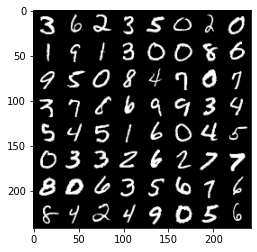

In [ ]:
%pylab inline
import numpy as np

def imshow(img):
    #img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## Как выглядит классификация с RNN в общем виде 

<img src="https://cdn-images-1.medium.com/max/1600/1*vhAfRLlaeOXZ-bruv7Ostg.png" width="400">

In [ ]:
class ImageRNN(nn.Module):
    def __init__(self, batch_size, n_steps, n_inputs, n_neurons, n_outputs):
        super().__init__()
        
        self.n_neurons = n_neurons
        self.batch_size = batch_size
        self.n_steps = n_steps
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        
        self.basic_rnn = nn.RNN(self.n_inputs, self.n_neurons) 
        
        self.FC = nn.Linear(self.n_neurons, self.n_outputs)
        
    def init_hidden(self,):
        # (num_layers, batch_size, n_neurons)
        return (torch.zeros(1, self.batch_size, self.n_neurons))
        
    def forward(self, X):
        # transforms X to dimensions: n_steps X batch_size X n_inputs
        X = X.permute(1, 0, 2) 
        
        self.batch_size = X.size(1)
        self.hidden = self.init_hidden()
        
        lstm_out, self.hidden = self.basic_rnn(X, self.hidden)      
        out = self.FC(self.hidden)
        
        return out.view(-1, self.n_outputs) # batch_size X n_output

In [ ]:
N_STEPS = 28
N_INPUTS = 28
N_NEURONS = 150
N_OUTPUTS = 10
N_EPHOCS = 10

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
logits = model(images.view(-1, 28,28))
print(logits[0:10])

tensor([[ 2.1558e-02,  5.9288e-03, -2.0235e-02,  7.9350e-03,  5.5360e-02,
          6.1271e-02,  5.6069e-02,  5.8132e-02, -9.5705e-02,  5.0924e-02],
        [ 2.2735e-02,  3.7988e-04, -1.4467e-02,  9.7223e-05,  5.3509e-02,
          6.2626e-02,  5.6102e-02,  5.4603e-02, -9.8078e-02,  4.9347e-02],
        [ 9.5168e-03, -1.1446e-03, -7.2977e-03, -7.1680e-04,  6.5967e-02,
          6.7333e-02,  5.3806e-02,  4.7146e-02, -1.1043e-01,  3.8765e-02],
        [ 1.2898e-02,  1.5707e-03, -4.3776e-03, -8.7226e-03,  3.4489e-02,
          5.9878e-02,  5.9914e-02,  5.1575e-02, -1.1969e-01,  4.8650e-02],
        [ 6.5920e-03,  2.3757e-03, -2.4636e-02,  1.5917e-02,  6.6583e-02,
          5.5023e-02,  6.5252e-02,  5.0842e-02, -1.0098e-01,  4.3480e-02],
        [-4.9940e-03, -3.8447e-02,  3.9068e-03,  1.6582e-02,  2.6627e-02,
          3.6895e-02,  7.5160e-02,  2.6513e-02, -1.1271e-01,  3.8257e-02],
        [ 1.4622e-02,  4.7463e-03, -9.2555e-03,  9.0226e-03,  6.3296e-02,
          6.1585e-02,  5.4375e-0

## Обучаем

In [ ]:
import torch.optim as optim

# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Model instance
model = ImageRNN(BATCH_SIZE, N_STEPS, N_INPUTS, N_NEURONS, N_OUTPUTS)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

def get_accuracy(logit, target, batch_size):
    ''' Obtain accuracy for training round '''
    corrects = (torch.max(logit, 1)[1].view(target.size()).data == target.data).sum()
    accuracy = 100.0 * corrects/batch_size
    return accuracy.item()

In [ ]:
for epoch in range(N_EPHOCS):
    train_running_loss = 0.0
    train_acc = 0.0
    model.train()
    
    # TRAINING ROUND
    for i, data in enumerate(trainloader):
         # zero the parameter gradients
        optimizer.zero_grad()
        
        # reset hidden states
        model.hidden = model.init_hidden() 
        
        # get the inputs
        inputs, labels = data
        inputs = inputs.view(-1, 28,28) 

        # forward + backward + optimize
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += get_accuracy(outputs, labels, BATCH_SIZE)
         
    model.eval()
    print('Epoch:  %d | Loss: %.4f | Train Accuracy: %.2f' 
          %(epoch, train_running_loss / i, train_acc/i))

Epoch:  0 | Loss: 0.7013 | Train Accuracy: 77.80
Epoch:  1 | Loss: 0.2888 | Train Accuracy: 91.63
Epoch:  2 | Loss: 0.2155 | Train Accuracy: 93.88
Epoch:  3 | Loss: 0.1797 | Train Accuracy: 94.93
Epoch:  4 | Loss: 0.1663 | Train Accuracy: 95.32


KeyboardInterrupt: ignored

### Смотрим что на тесте

In [ ]:
test_acc = 0.0
for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs = inputs.view(-1, 28, 28)

    outputs = model(inputs)

    test_acc += get_accuracy(outputs, labels, BATCH_SIZE)
        
print('Test Accuracy: %.2f'%( test_acc/i))

Test Accuracy: 96.44


# Сентимент анализ

Домашка — классифицировать отзывы с IMDB на положительный / отрицательный только по тексту.

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment1.png">

Суть такая же, только нужно предобработать тексты — каждому слову сопоставить обучаемый вектор (embedding), который пойдёт дальше в RNN.

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import numpy as np


In [4]:
# это уберет боль работы с текстами
!pip install torchtext==0.4.0
!python -m spacy download en

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.12.0
    Uninstalling torchtext-0.12.0:
      Successfully uninstalled torchtext-0.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 12.0 MB 25.1 MB/s 
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.7/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.7/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


**Примечание.** Torchtext уже не очень живой проект, а в spacy нет русского.


In [5]:
import torch
from torchtext import data


SEED = 1234
batch_size = 3
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

TEXT = data.Field(tokenize='spacy')
LABEL = data.LabelField(dtype=torch.float)

In [6]:
from torchtext import datasets
train_data, test_data = datasets.IMDB.splits(TEXT, LABEL, root="./data")

downloading aclImdb_v1.tar.gz


aclImdb_v1.tar.gz: 100%|██████████| 84.1M/84.1M [00:03<00:00, 22.8MB/s]


In [7]:
!ls -lh data/imdb/aclImdb/

total 1.7M
-rw-r--r-- 1 7297 1000 882K Jun 11  2011 imdbEr.txt
-rw-r--r-- 1 7297 1000 827K Apr 12  2011 imdb.vocab
-rw-r--r-- 1 7297 1000 4.0K Jun 26  2011 README
drwxr-xr-x 4 7297 1000 4.0K Apr 12  2011 test
drwxr-xr-x 5 7297 1000 4.0K Jun 26  2011 train


In [8]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 25000
Number of testing examples: 25000


In [9]:
print(vars(train_data.examples[0]))

{'text': ['Well', ',', 'I', 'get', 'used', 'after', 'awhile', 'to', 'read', 'comments', 'about', 'these', 'movies', 'that', 'do', "n't", 'reflect', 'my', 'experience', 'at', 'all', '.', 'To', 'me', ',', 'Amitabh', 'was', 'a', 'better', 'villain', 'here', 'than', 'in', 'some', 'of', 'his', 'most', 'famous', 'movies', '.', 'He', 'was', 'a', 'die', '-', 'hard', 'villain', ',', 'a', 'no', '-', 'apologies', 'villain', '.', 'To', 'me', 'it', 'was', 'a', 'breath', 'of', 'fresh', 'air', 'to', 'see', 'him', 'in', 'a', 'role', 'where', 'his', 'villainy', 'is', "n't", 'sort', 'of', 'undercut', 'in', 'some', 'way.<br', '/><br', '/>The', 'kid', 'who', 'played', 'Aryan', 'was', 'probably', 'over', 'his', 'head', 'with', 'this', 'cast', '.', 'There', 'I', 'think', 'maybe', 'the', 'director', 'could', 'have', 'done', 'better', '.', 'But', ',', 'to', 'be', 'honest', ',', 'the', 'very', 'best', 'part', 'of', 'this', 'movie', 'was', 'Shernaz', 'Patel', '.', 'She', 'is', 'an', 'unsung', 'heroine', ',', 'a

In [10]:
# Сделаем еще eval
import random

train_data, valid_data = train_data.split(random_state=random.seed(SEED))
# train_iter, test_iter = data.BucketIterator.splits(
#     (train_data, valid_data), batch_size=batch_size, device="cuda:0")

In [11]:
# Сделаем словарь
TEXT.build_vocab(train_data, max_size=25000)
LABEL.build_vocab(train_data)

In [12]:
print(f"Unique tokens in TEXT vocabulary: {len(TEXT.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in TEXT vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


In [13]:
vars(LABEL.vocab)

{'freqs': Counter({'neg': 8810, 'pos': 8690}),
 'itos': ['neg', 'pos'],
 'stoi': defaultdict(None, {'neg': 0, 'pos': 1}),
 'unk_index': None,
 'vectors': None}

Почему 25002, а не 25000?
Потому что $<unk>$ и $<pad>$

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment6.png" width="160">

In [14]:
print(TEXT.vocab.freqs.most_common(20))

[('the', 202430), (',', 191792), ('.', 165320), ('and', 109607), ('a', 109014), ('of', 100748), ('to', 93626), ('is', 76016), ('in', 61048), ('I', 53704), ('it', 53544), ('that', 48912), ('"', 44522), ("'s", 43156), ('this', 42289), ('-', 37313), ('/><br', 35570), ('was', 34867), ('as', 30528), ('with', 29774)]


* stoi (string to int)
* itos (int to string)

In [15]:
print(TEXT.vocab.itos[:10])

['<unk>', '<pad>', 'the', ',', '.', 'and', 'a', 'of', 'to', 'is']


In [16]:
print(LABEL.vocab.stoi)

defaultdict(None, {'neg': 0, 'pos': 1})


In [17]:
BATCH_SIZE = 64

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# собираем батчи так, чтобы в каждом батче были примеры наиболее похожей длины
train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data), 
    batch_size=BATCH_SIZE,
    device=device)

## Делаем модель

<img src="https://github.com/bentrevett/pytorch-sentiment-analysis/raw/bf8cc46e4823ebf9af721b595501ad6231c73632/assets/sentiment7.png" width="450">

* В эмбеддер (emb = [torch.nn.Embedding(num_embeddings, embedding_dim)](https://pytorch.org/docs/stable/nn.html?highlight=embedding#torch.nn.Embedding)) запихиваем тензор размерностью **[sentence length, batch size]**
* Эмбеддер возвращает тензор размерностью **[sentence length, batch size, embedding dim]**
* RNN (torch.nn.RNN(embedding_dim, hidden_dim)) возвращает 2 тензора, *output* размера [sentence length, batch size, hidden dim] и *hidden* размера [1, batch size, hidden dim]

In [94]:

class RNN(nn.Module):
    def __init__(self, input_dim, embedding_dim, hidden_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embedding_dim = embedding_dim
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim)
        self.fc = nn.Linear(self.hidden_dim, output_dim) # можно добавить линейный слой, который делает проекцию в 2 класса
    

    def init_hidden(self, batch_size):
        # (num_layers, batch_size, n_neurons)
        self.hidden = (torch.zeros(1, batch_size, self.hidden_dim))


    def forward(self, X):
        #text,shape = [sent len, batch size]
        embedded = self.embedding(X)
        
        #embedded.shape = [sent len, batch size, emb dim]
        # self.hidden = self.init_hidden()
        #self.hidden = self.hidden.to(device)
        output, self.hidden = self.rnn(embedded)
        
        #output.shape = [sent len, batch size, hid dim]
        #hidden.shape = [1, batch size, hid dim]
        
#         assert torch.equal(output[-1,:,:], hidden.squeeze(0))
        
        return self.fc(self.hidden.squeeze(0))

In [95]:
# код обучения тоже пишите вы:)
import torch.optim as optim
hidden_size = 200
num_epochs = 10
EMD_DIM = 300
model = RNN(len(TEXT.vocab), EMD_DIM, hidden_size, 2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses = []
# model.init_hidden(BATCH_SIZE)


In [96]:
def accuracy(model, val):
    model.eval()
    score = [(torch.argmax(model(text), 1) == label).float().mean().item() for text, label in val]
    return np.mean(score)

In [103]:
for _ in range(num_epochs):
  train_running_loss = 0.0
  train_acc = 0.0
  model.train()
  for x, y in train_iterator:
    x = x.to(device)
    y = y.to(device)
    optimizer.zero_grad()
    pred = model(x)
    #y = F.one_hot(y.to(torch.int64), num_classes=2)
    # print(pred.float(), y)
    loss = criterion(pred, y.long())
    
    optimizer.step()

    train_losses.append(loss.item())
   
  
  print('Epoch {} | Train accuracy : {} | Val accuracy : {}'.format(_, accuracy(model, train_iterator), accuracy(model, valid_iterator)))

Epoch 0 | Train accuracy : 0.5049449296763343 | Val accuracy : 0.4954537431062278
Epoch 1 | Train accuracy : 0.5038044187274292 | Val accuracy : 0.4954537431062278
Epoch 2 | Train accuracy : 0.5038532977991731 | Val accuracy : 0.4954537431062278
Epoch 3 | Train accuracy : 0.5036170491336907 | Val accuracy : 0.4954537431062278
Epoch 4 | Train accuracy : 0.5036577816209654 | Val accuracy : 0.4954537431062278
Epoch 5 | Train accuracy : 0.504219890510949 | Val accuracy : 0.4954537431062278
Epoch 6 | Train accuracy : 0.5042932092273322 | Val accuracy : 0.4954537431062278
Epoch 7 | Train accuracy : 0.5037799793003249 | Val accuracy : 0.4954537431062278
Epoch 8 | Train accuracy : 0.5048390250571453 | Val accuracy : 0.4954537431062278
Epoch 9 | Train accuracy : 0.504228037095418 | Val accuracy : 0.4954537431062278


In [ ]:
rnn = nn.RNN(10, 20, 2)
input = torch.randn(5, 3, 10)
h0 = torch.randn(2, 3, 20)
output, hn = rnn(input, h0)

In [ ]:
output.shape, hn.shape
